# Student Dropout Analysis

**Annabel Lim, Owen Kwong, Yash Mali, Yui Mikuriya (Group 20)**

## 1. Introduction



Higher education institutions worldwide are attempting to effectively address diverse student learning styles and academic performances to enhance the learning experience. One interesting topic to consider is the dropout rate within higher education along with exploration of its root causes. A key factor that affects college graduation rates is that students with better academic performance in high school are more likely to graduate from college. 

The goal of this project is to determine if students who dropped out had lower admission grades than the students who graduated. The Polytechnic Institute of Portalegre (IPP) has a dataset with student data from four schools in Portugal. It provides data on nationality, admission grades, and graduation status. To explore this goal, we have formulated the below research question:

**Research Question:** *Research Question: Is there enough evidence to suggest that admission grades of students who dropped out are lower than students who graduated?*


## 2. Preliminary Results

We start by loading libraries, setting the seed, and importing the dataset into a dataframe.

In [42]:
# load libraries
library(cowplot)
library(datateachr)
library(digest)
library(infer)
library(repr)
library(taxyvr)
library(tidyverse)
library(dplyr)
library(datateachr)

# set seed
set.seed(2023);

# number rows for table 
options(repr.matrix.max.rows = 8)

In [43]:
# data url (zip file)
url <- "https://archive.ics.uci.edu/static/public/697/predict+students+dropout+and+academic+success.zip"

# unzip and load data
temp <- tempfile()
download.file(url,temp)
dropout_data <- read.csv2(unz(temp, "data.csv")) 
unlink(temp)

head(dropout_data) # shows that there are 4424 student entries

,Marital.status,Application.mode,Application.order,Course,Daytime.evening.attendance.,Previous.qualification,Previous.qualification..grade.,Nacionality,Mother.s.qualification,Father.s.qualification,⋯,Curricular.units.2nd.sem..credited.,Curricular.units.2nd.sem..enrolled.,Curricular.units.2nd.sem..evaluations.,Curricular.units.2nd.sem..approved.,Curricular.units.2nd.sem..grade.,Curricular.units.2nd.sem..without.evaluations.,Unemployment.rate,Inflation.rate,GDP,Target
,<int>,<int>,<int>,<int>,<int>,<int>,<chr>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>
1,1,17,5,171,1,1,122.0,1,19,12,⋯,0,0,0,0,0.0,0,10.8,1.4,1.74,Dropout
2,1,15,1,9254,1,1,160.0,1,1,3,⋯,0,6,6,6,13.666666666666666,0,13.9,-0.3,0.79,Graduate
3,1,1,5,9070,1,1,122.0,1,37,37,⋯,0,6,0,0,0.0,0,10.8,1.4,1.74,Dropout
4,1,17,2,9773,1,1,122.0,1,38,37,⋯,0,6,10,5,12.4,0,9.4,-0.8,-3.12,Graduate
5,2,39,1,8014,0,1,100.0,1,37,38,⋯,0,6,6,6,13.0,0,13.9,-0.3,0.79,Graduate
6,2,39,1,9991,0,19,133.1,1,37,37,⋯,0,5,17,5,11.5,5,16.2,0.3,-0.92,Graduate


Figure 1. Imported tibble of IPP student dropout data

### Variables Information
The description of columns are given by the data set information on the UCI Machine Learning Repository page.

**Admission.grade:** Students' admission grade is standardized (0-200).

**Target:** Student can be classified as three different types (dropout, enrolled, graduate).

### Cleaning the Data

Our data is already in a "tidy" format with no missing values, allowing us to skip the consideration of NA values. 

However, we can further clean up the data by: 
1. rename column names
2. convert Student_Status column to a factor
3. filter "Droupout" and "Graduated" in Student_Status
4. select only relevant columns

In [44]:
#Clean the data 
dropout_clean <- dropout_data %>% 
  rename(Student_Status = Target,
         Admission_Grade = Admission.grade) %>% #Rename 'Target' column
  mutate(Student_Status = as_factor(Student_Status)) %>% #Convert the 'Student_Status' column to a factor
  filter(Student_Status != "Enrolled") 

#Select only the Target column 
dropout_pop <- dropout_clean %>%
  select(Student_Status, Admission_Grade) %>%
  mutate(Admission_Grade = as.numeric(Admission_Grade))

head(dropout_pop)

,Student_Status,Admission_Grade
,<fct>,<dbl>
1,Dropout,127.3
2,Graduate,142.5
3,Dropout,124.8
4,Graduate,119.6
5,Graduate,141.5
6,Graduate,114.8


To ensure that our sample is representative of our population of interest, we calculated the number of observations from each. With 1421 observations from students who dropped out and 2209 from students who graduated, this dataset is suited to answer our research question.

In [45]:
dropout_count <- dropout_pop %>%
    group_by(Student_Status) %>%
    summarize(count_column = n()) 
dropout_count 

Student_Status,count_column
<fct>,<int>
Dropout,1421
Graduate,2209


### Regrouping and summarizing response variable

We calculate the sample mean of admission grades for both dropout and graduated students to obtain preliminary results regarding their differences by regrouping the response variable.

In [46]:
dropout_summarize <- dropout_pop %>%
    group_by(Student_Status) %>%
    summarize(mean_admission_grade = mean(Admission_Grade))

dropout_mean <- dropout_summarize["1","mean_admission_grade", drop=TRUE]
graduates_mean <- dropout_summarize["2","mean_admission_grade", drop=TRUE]

dropout_summarize

Student_Status,mean_admission_grade
<fct>,<dbl>
Dropout,124.9614
Graduate,128.7944


### Data Analysis and Visualizations

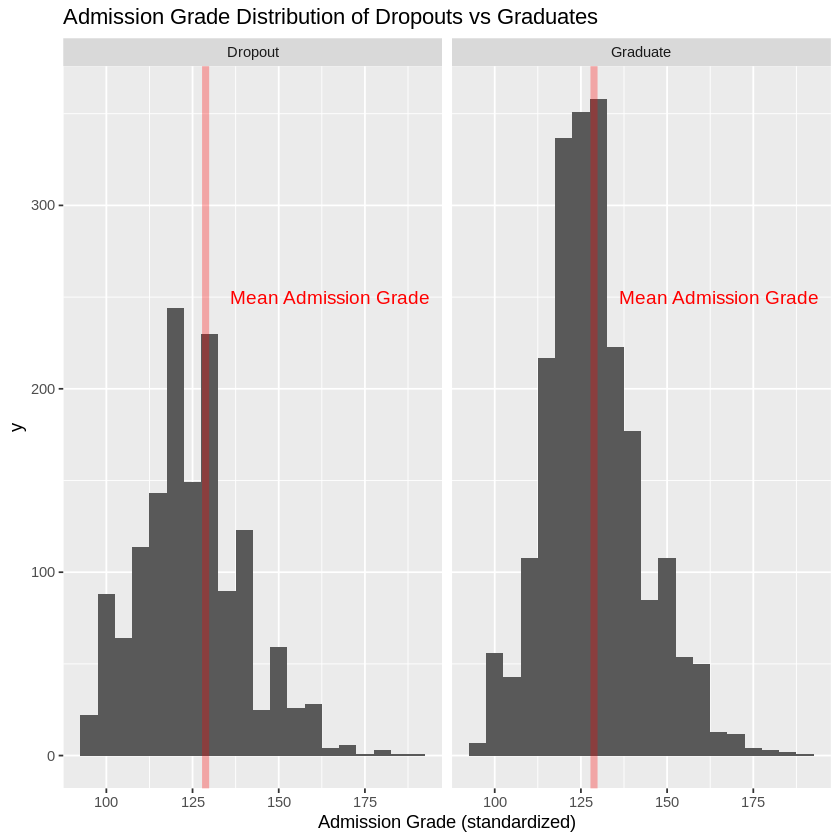

In [47]:
distribution <- dropout_pop %>%
  ggplot(aes(x = Admission_Grade)) +
  geom_histogram(bins=20) +
  ggtitle("Admission Grade Distribution of Dropouts vs Graduates") +
  labs(x="Admission Grade (standardized)") +
  geom_vline(aes(xintercept = graduates_mean), color = "red", alpha = 0.3, lwd = 2) +
  annotate("text", x = 165, y = 250, label = "Mean Admission Grade", color = "red", size = 4) +
  facet_wrap(~Student_Status, ncol = 2)

distribution

Figure 2. Tidied tibble of IPP student dropout data

From the above graph, we can see that the data is normally distributed.

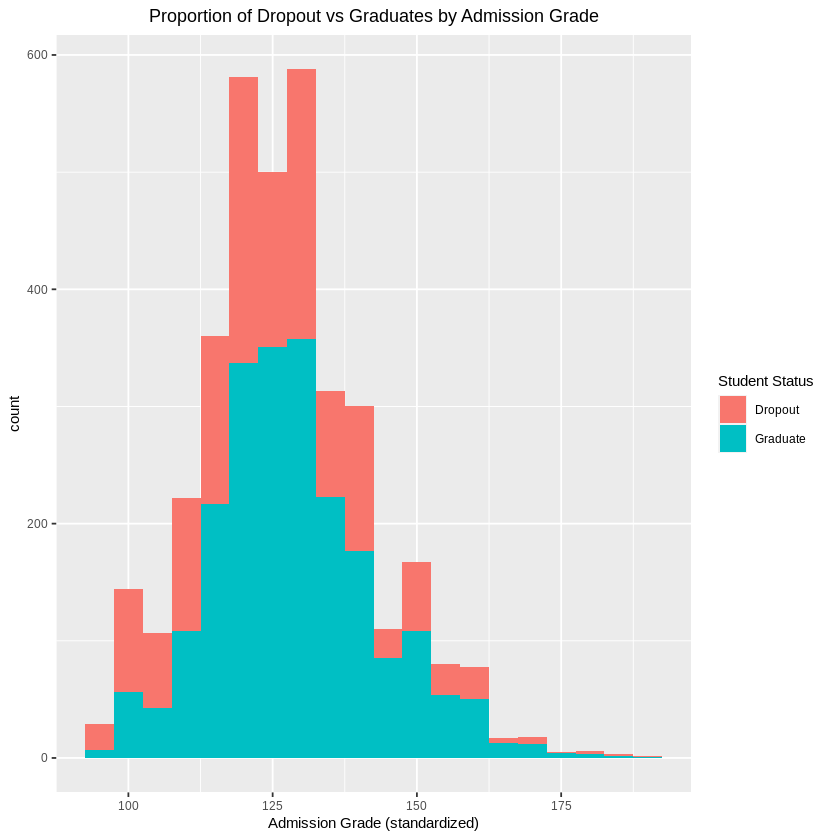

In [48]:
# plot proportion of dropout vs graduated students by admission grade  
target_vs_grade <- dropout_pop |>
    ggplot(aes(x = Admission_Grade, fill = Student_Status)) +
        geom_histogram(binwidth=5) +
        labs(x = "Admission Grade (standardized)", fill = "Student Status") +
        ggtitle("Proportion of Dropout vs Graduates by Admission Grade") +
        theme(text = element_text(size=9)) +
        theme(plot.title = element_text(hjust = 0.5))

target_vs_grade

Figure 3. Proportion of Dropout vs Graduates by Admission Grade

## 3. Methods: Plan

The credibility of this report hinges on a reliable dataset, as the IPP has previously leveraged this data to construct machine learning classification models for forecasting students' challenges in completing their degrees.

We plan to conduct a one-sided hypothesis test to examine if there is enough evidence to suggest that the admission grades of dropout students are lower than graduated students. This can be represented in the following hypothesis where $m_1$ is the mean admission grade of dropout students and $m_2$ is the mean admission grade of graduated students.

$H_0: m_1-m_2 = 0$

$H_1: m_1-m_2 < 0$

**Method outline:**
- Find point estimate
- Use the infer workflow to simulate from the null distribution
- Conduct hypothesis test with p-value using $\alpha = 0.05$
- To access results, use bootstrapping method and conduct hypothesis test with a 95% CI
- Compare and interpret results of the p-value and CI 

**Reflections:**
    
One outcome that we may find is that students who dropped out have lower admission grades compared to students who did not drop out. This finding may indicate that students entering higher education with weaker academic backgrounds are more likely to experience attrition. This research can serve as a stepping stone for further investigations into how to strengthen the academic knowledge of these vulnerable students.

## 4. References

Realinho,Valentim, Vieira Martins,Mónica, Machado,Jorge, and Baptista,Luís. (2021). Predict students' dropout and academic success. UCI Machine Learning Repository. https://doi.org/10.24432/C5MC89.

Kantrowitz, M. (2021, November 19). Shocking statistics about college graduation rates. Forbes. https://www.forbes.com/sites/markkantrowitz/2021/11/18/shocking-statistics-about-college-graduation-rates/?sh=162e8c1f2b69